## Import Libraries and Datasets

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.preprocessing as skpre
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
# Load in the persons PUMS dataset for WA state
p_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_p53.csv")
h_df = pd.read_csv("data/PUMS_2017_5YR_WA/psam_h53.csv")

## Choose Variables and Preprocess

In [3]:
# Filter to desired variables (numeric then categorical)
pums_data_p = p_df[['SERIALNO','AGEP','JWMNP','SCHL','PINCP','COW','SEX','MAR']]
pums_data_h = h_df[['SERIALNO','NP','VEH','HINCP']]
pums_data = pd.merge(pums_data_p, pums_data_h, on='SERIALNO')
pums_data = pums_data.drop(labels=['SERIALNO'], axis=1)
pums_data = pums_data[['AGEP','JWMNP','SCHL','PINCP','HINCP','COW','SEX','MAR','NP','VEH']]

# Remove NA values and check n before/after
print(f"Dataset n={len(pums_data)} pre-cleaning")
pums_data = pums_data.dropna()
print(f"Dataset n={len(pums_data)} post-cleaning")

Dataset n=359075 pre-cleaning
Dataset n=150203 post-cleaning


In [4]:
CAT_IDX = 5
HH_IDX = [4,8,9]
LEN_PERS = pums_data_p.shape[1] - 1
LEN_HH = pums_data_h.shape[1] - 1
VAR_DIM = pums_data.shape[1] #Length of all variables before OHE
VAR_NAMES = pums_data.columns #Names of all variables before OHE

# Split categorical data into OHE vars, save num classes per variable
dummies_list = []
for x in range(CAT_IDX, VAR_DIM):
    dummies = pums_data.iloc[:,x]
    dummies = pd.get_dummies(dummies, prefix=f"{pums_data.columns[x]}_")
    dummies_list.append(dummies)
CAT_LENGTHS = [x.shape[1] for x in dummies_list]
print(f"Categorical variable class lengths: {CAT_LENGTHS}")

Categorical variable class lengths: [8, 2, 5, 18, 7]


In [5]:
# Final data frame after encoding OHE
model_data_df = pums_data.iloc[:,:CAT_IDX]
for ohe_var in dummies_list:
    model_data_df = pd.concat([model_data_df, ohe_var], axis=1)
MANIFEST_DIM = model_data_df.shape[1]

# Add columns for original household variables; these will be fed to decoder but not encoder
model_data_df = pd.concat([model_data_df, pums_data.iloc[:,HH_IDX]], axis=1)

# Preview data that will be fed into model
model_data_df

,AGEP,JWMNP,SCHL,PINCP,HINCP,COW__1.0,COW__2.0,COW__3.0,COW__4.0,COW__5.0,...,VEH__0.0,VEH__1.0,VEH__2.0,VEH__3.0,VEH__4.0,VEH__5.0,VEH__6.0,HINCP,NP,VEH
4,52,70.0,21.0,160000.0,210500.0,1,0,0,0,0,...,0,0,0,1,0,0,0,210500.0,3,3.0
5,51,20.0,21.0,50000.0,210500.0,0,0,1,0,0,...,0,0,0,1,0,0,0,210500.0,3,3.0
7,59,30.0,19.0,26710.0,50310.0,0,0,1,0,0,...,0,0,0,1,0,0,0,50310.0,2,3.0
8,56,15.0,16.0,23600.0,50310.0,1,0,0,0,0,...,0,0,0,1,0,0,0,50310.0,2,3.0
9,40,5.0,5.0,10000.0,31200.0,1,0,0,0,0,...,1,0,0,0,0,0,0,31200.0,5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
356007,37,50.0,21.0,55000.0,55000.0,1,0,0,0,0,...,0,0,1,0,0,0,0,55000.0,3,2.0
356010,33,65.0,18.0,90000.0,102000.0,1,0,0,0,0,...,0,0,1,0,0,0,0,102000.0,4,2.0
356013,48,60.0,18.0,48400.0,106400.0,1,0,0,0,0,...,0,0,0,0,1,0,0,106400.0,3,4.0
356014,49,30.0,19.0,49000.0,106400.0,1,0,0,0,0,...,0,0,0,0,1,0,0,106400.0,3,4.0


In [6]:
# Standardize the input data from -1 to 1 for numerical variables
scaler_pers = skpre.StandardScaler()
scaler_hh = skpre.StandardScaler()
model_data = model_data_df.values
model_data[:,:CAT_IDX] = scaler_pers.fit_transform(model_data[:,:CAT_IDX])
model_data[:,MANIFEST_DIM:] = scaler_hh.fit_transform(model_data[:,MANIFEST_DIM:])

# Remove rows with numerical outliers (3 < standard deviations)
print(f"Dataset n={len(model_data)} pre-numerical-outliers")
outlier_row_indices = np.where(np.any(model_data[:,:CAT_IDX] > 3, axis=1))
model_data = np.delete(model_data, (outlier_row_indices), axis=0)
print(f"Dataset n={len(model_data)} post-numerical-outliers")

# Separate into train/test data
train_idx = round(len(model_data)*.9)
train_data = model_data[0:train_idx,:]
test_data = model_data[train_idx:len(model_data),:]

Dataset n=150203 pre-numerical-outliers
Dataset n=143451 post-numerical-outliers


## Set Parameters and Define Model

### TODO:

###### Build up fundamental model:
-Generate a synthetic hh/pers tables for WA  
-Test speeds vs traditional methods  
-Energy distance test for distributions  

###### Differentiate from the GenSynth paper:
-Travel diaries  
-Method/heuristic/rules for checking large number of attributes  
-New models; Disentangled VAE/GAN  
-Model population changes over time RNN?  
-Behavioral variables  

###### They suggest:
-Incorporate RNN to generate trip chains (time, location, mode, purpose)  
-Use GAN/other method to generate less inconsistencies  
-Address next stage of re-sampling to get future populations  

In [7]:
# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 100
LEARN_RATE = 0.001
RHO = 0.9
LATENT_DIM = 5
HIDDEN_DIM = 100
KL_WEIGHT = 0.5

In [8]:
# A layer that takes mean/variance as inputs and returns a random sample z
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(z_log_var) * epsilon

In [9]:
# Encoder
encoder_inputs = keras.Input(shape=(MANIFEST_DIM,))
encoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(encoder_inputs)
encoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(encoder_x)
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(encoder_x)
z_log_var = layers.Dense(LATENT_DIM, name="z_log_var")(encoder_x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 100)          4600        input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 100)          10100       dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 5)            505         dense_1[0][0]                    
____________________________________________________________________________________________

In [10]:
# Decoder
decoder_inputs = keras.Input(shape=(LATENT_DIM + LEN_HH,))
decoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(decoder_inputs)
decoder_x = layers.Dense(HIDDEN_DIM, activation="tanh")(decoder_x)
decoder_num_outputs = layers.Dense(CAT_IDX, activation="linear")(decoder_x)
decoder_cat_outputs = []
for var_length in CAT_LENGTHS:
    layer = layers.Dense(var_length, activation="softmax")(decoder_x)
    decoder_cat_outputs.append(layer)
decoder = keras.Model(decoder_inputs, [decoder_num_outputs, decoder_cat_outputs], name="decoder")
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 100)          900         input_2[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 100)          10100       dense_2[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 5)            505         dense_3[0][0]                    
____________________________________________________________________________________________

In [11]:
# Define custom loss function for combined numerical and categorical data
def get_reconstruction_loss(data, reconstruction, CAT_IDX, CAT_LENGTHS):

    # Mean squared error for numerical variables
    data_num = data[:,:CAT_IDX]
    reconstruction_num = reconstruction[0]
    loss_num = keras.losses.mean_squared_error(data_num, reconstruction_num)
    loss_num = tf.reduce_mean(loss_num)
    
    # Categorical cross entropy for categorical variables
    loss_list = []
    current = CAT_IDX
    for i, x in enumerate(CAT_LENGTHS):
        data_cat = data[:,current:(current + x)]
        reconstruction_cat = reconstruction[1][i]
        loss = keras.losses.categorical_crossentropy(data_cat, reconstruction_cat, from_logits=False)
        loss = tf.reduce_mean(loss)
        loss_list.append(loss)
        current += x
    loss_cat = tf.reduce_sum(loss_list)

    # Return both losses; they are combined in the model
    return (loss_num, loss_cat)

def get_kl_loss(z_mean, z_log_var):
    kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
    kl_loss = tf.reduce_mean(kl_loss)
    kl_loss = -kl_loss
    return kl_loss

In [12]:
# Loss metric recorder
loss_tracker = keras.metrics.Mean(name="loss")

# Variational Autoencoder
class VAE(keras.Model):
    def __init__(self, encoder, decoder, CAT_IDX, CAT_LENGTHS, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.CAT_IDX = CAT_IDX
        self.CAT_LENGTHS = CAT_LENGTHS

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            # Get latent vars from the encoder; feed to decoder and get sampled manifest variables
            z_mean, z_log_var, z = encoder(data[:,:MANIFEST_DIM])
            decoder_input = tf.concat([z, data[:,MANIFEST_DIM:]], axis=1)
            reconstruction = decoder(decoder_input)

            # Get loss between input values and reconstruction
            reconstruction_loss_num, reconstruction_loss_cat = get_reconstruction_loss(
                data,
                reconstruction,
                self.CAT_IDX,
                self.CAT_LENGTHS
            )
            reconstruction_loss = tf.add(reconstruction_loss_num, reconstruction_loss_cat)

            # Get Kullback Leidler loss between normal distribution and actual for latent variables
            kl_loss = get_kl_loss(z_mean, z_log_var)
            kl_loss = kl_loss * KL_WEIGHT

            # Combine into single loss term
            total_loss = reconstruction_loss + kl_loss

        # Get new gradients given the loss and take another step (update weights)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Record the loss metrics
        loss_tracker.update_state(total_loss)

        return {
            "total_loss": loss_tracker.result(),
            "reconstruction_loss": reconstruction_loss,
            "reconstruction_loss_num": reconstruction_loss_num,
            "reconstruction_loss_cat": reconstruction_loss_cat,
            "kl_loss": kl_loss,
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs[:,:MANIFEST_DIM])
        decoder_input = tf.concat([z, inputs[:,MANIFEST_DIM:]], axis=1)
        reconstruction = self.decoder(decoder_input)
        return reconstruction

    @property
    def metrics(self):
        return [loss_tracker]

## Training

In [13]:
# Train
vae = VAE(encoder, decoder, CAT_IDX, CAT_LENGTHS)
vae.compile(optimizer=keras.optimizers.RMSprop(learning_rate=LEARN_RATE, rho=RHO))
history = vae.fit(train_data, epochs=EPOCHS, batch_size=BATCH_SIZE) #add callbacks=[callback] if debugging needed

Epoch 1/100
2018/2018 [==============================] - 9s 4ms/step - total_loss: 2.7447 - reconstruction_loss: 1.1963 - reconstruction_loss_num: 0.4161 - reconstruction_loss_cat: 0.7803 - kl_loss: 0.6379
Epoch 2/100
2018/2018 [==============================] - 7s 4ms/step - total_loss: 1.1091 - reconstruction_loss: 0.4527 - reconstruction_loss_num: 0.2972 - reconstruction_loss_cat: 0.1555 - kl_loss: 0.5940
Epoch 3/100
2018/2018 [==============================] - 8s 4ms/step - total_loss: 0.9314 - reconstruction_loss: 0.3270 - reconstruction_loss_num: 0.2326 - reconstruction_loss_cat: 0.0943 - kl_loss: 0.5855
Epoch 4/100
2018/2018 [==============================] - 9s 5ms/step - total_loss: 0.8794 - reconstruction_loss: 0.2931 - reconstruction_loss_num: 0.2162 - reconstruction_loss_cat: 0.0769 - kl_loss: 0.5799
Epoch 5/100
2018/2018 [==============================] - 11s 6ms/step - total_loss: 0.8531 - reconstruction_loss: 0.2749 - reconstruction_loss_num: 0.2075 - reconstruction_loss

2018/2018 [==============================] - 6s 3ms/step - total_loss: 0.7541 - reconstruction_loss: 0.1997 - reconstruction_loss_num: 0.1603 - reconstruction_loss_cat: 0.0394 - kl_loss: 0.5549
Epoch 41/100
2018/2018 [==============================] - 6s 3ms/step - total_loss: 0.7552 - reconstruction_loss: 0.2026 - reconstruction_loss_num: 0.1617 - reconstruction_loss_cat: 0.0409 - kl_loss: 0.5533
Epoch 42/100
2018/2018 [==============================] - 6s 3ms/step - total_loss: 0.7539 - reconstruction_loss: 0.2033 - reconstruction_loss_num: 0.1622 - reconstruction_loss_cat: 0.0411 - kl_loss: 0.5509
Epoch 43/100
2018/2018 [==============================] - 9s 4ms/step - total_loss: 0.7517 - reconstruction_loss: 0.2021 - reconstruction_loss_num: 0.1624 - reconstruction_loss_cat: 0.0397 - kl_loss: 0.5500
Epoch 44/100
2018/2018 [==============================] - 9s 5ms/step - total_loss: 0.7488 - reconstruction_loss: 0.2003 - reconstruction_loss_num: 0.1617 - reconstruction_loss_cat: 0.0

2018/2018 [==============================] - 6s 3ms/step - total_loss: 0.7310 - reconstruction_loss: 0.1887 - reconstruction_loss_num: 0.1503 - reconstruction_loss_cat: 0.0384 - kl_loss: 0.5406
Epoch 80/100
2018/2018 [==============================] - 5s 3ms/step - total_loss: 0.7292 - reconstruction_loss: 0.1894 - reconstruction_loss_num: 0.1504 - reconstruction_loss_cat: 0.0390 - kl_loss: 0.5405
Epoch 81/100
2018/2018 [==============================] - 5s 3ms/step - total_loss: 0.7295 - reconstruction_loss: 0.1875 - reconstruction_loss_num: 0.1500 - reconstruction_loss_cat: 0.0376 - kl_loss: 0.5404
Epoch 82/100
2018/2018 [==============================] - 5s 3ms/step - total_loss: 0.7311 - reconstruction_loss: 0.1894 - reconstruction_loss_num: 0.1503 - reconstruction_loss_cat: 0.0391 - kl_loss: 0.5423
Epoch 83/100
2018/2018 [==============================] - 5s 3ms/step - total_loss: 0.7271 - reconstruction_loss: 0.1883 - reconstruction_loss_num: 0.1501 - reconstruction_loss_cat: 0.0

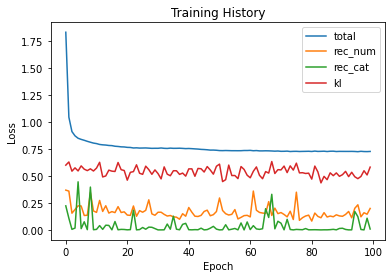

In [14]:
# Plot model loss/training progress
plt.plot(history.history['total_loss'])
plt.plot(history.history['reconstruction_loss_num'])
plt.plot(history.history['reconstruction_loss_cat'])
plt.plot(history.history['kl_loss'])
plt.title("Training History")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["total","rec_num","rec_cat","kl"], loc="upper right")
plt.show()

## Testing

Latent Variable: 0
Mean: 0.04835601896047592
Variance: 1.1677987575531006



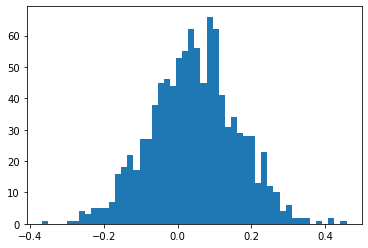

Latent Variable: 1
Mean: -0.034213971346616745
Variance: 1.1677987575531006



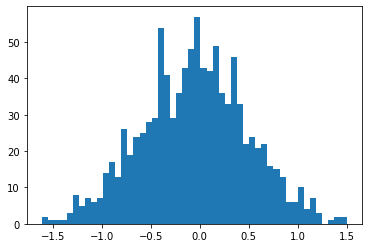

Latent Variable: 2
Mean: 0.07937712967395782
Variance: 1.1677987575531006



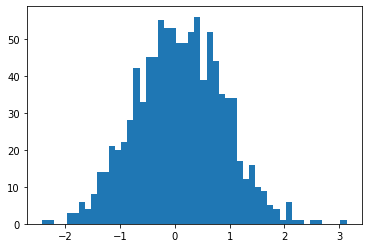

Latent Variable: 3
Mean: -0.029138265177607536
Variance: 1.1677987575531006



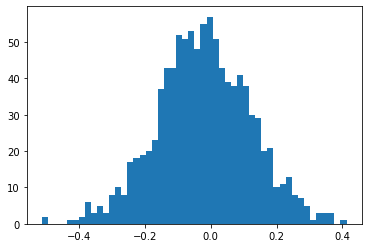

Latent Variable: 4
Mean: 0.018337134271860123
Variance: 1.1677987575531006



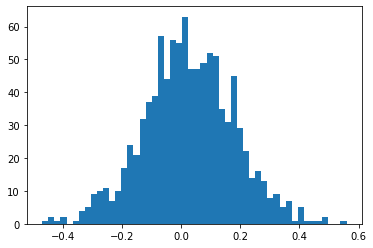

In [37]:
# Get latent vars from the encoder; feed to decoder and get sampled manifest variables
z_mean, z_logvar, z = vae.encoder.predict(test_data[:,:MANIFEST_DIM])

# Determine the average values for the mean/logvariance of the latent variables
for i in range(0, LATENT_DIM):
    epsilon = np.random.normal(loc=0, scale=1, size=1000)
    avg_mean = np.mean(z_mean[:,i])
    avg_var = np.exp(np.mean(z_logvar[:,i]))
    print(f"Latent Variable: {i}")
    print(f"Mean: {avg_mean}")
    print(f"Variance: {np.exp(avg_logvar)}\n")
    samples = avg_mean + (avg_var * epsilon)
    plt.hist(samples, bins=50)
    plt.show()

In [16]:
# Draw predictions from test data
results = vae.predict(test_data)
loss_num, loss_cat = get_reconstruction_loss(test_data, results, CAT_IDX, CAT_LENGTHS)
print(f"Numerical Variable Loss: {loss_num}")
print(f"Categorical Variable Loss: {loss_cat}")

Numerical Variable Loss: 0.1441044956445694
Categorical Variable Loss: 0.03415510803461075


In [17]:
# Transform numeric results back to real variable values
results_num = scaler_pers.inverse_transform(results[0])
results_df = pd.DataFrame(results_num)

# Transform categorical results back to real variable values
for x in results[1]:
    result = np.argmax(x, axis=1) + 1
    results_df[f"{x}"] = result

# Add back original variables names to the results
results_df.columns = VAR_NAMES

In [18]:
# Transform numeric test data back to real variable values
test_data_num = scaler_pers.inverse_transform(test_data[:,:CAT_IDX])
test_data_df = pd.DataFrame(test_data_num)

# Transform categorical test data back to real variable values
current = CAT_IDX
for x in CAT_LENGTHS:
    test_data_cat = test_data[:,current:(current + x)]
    test_data_cat = np.argmax(test_data_cat, axis=1) + 1
    test_data_df[f"{x}"] = test_data_cat
    current += x

# Add back original variables names to the test data
test_data_df.columns = VAR_NAMES

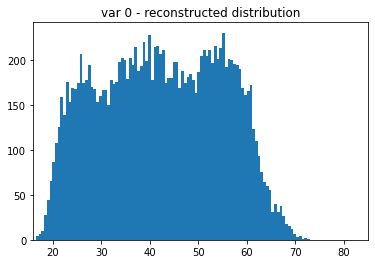

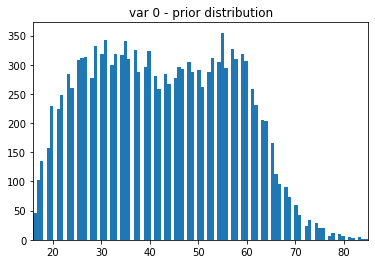

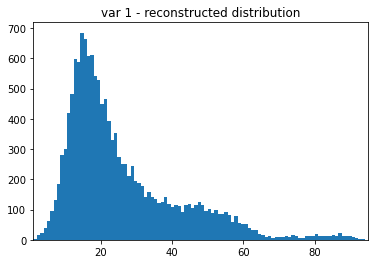

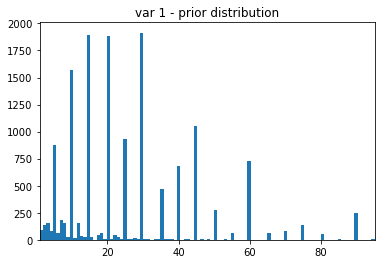

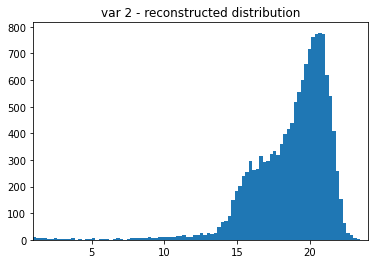

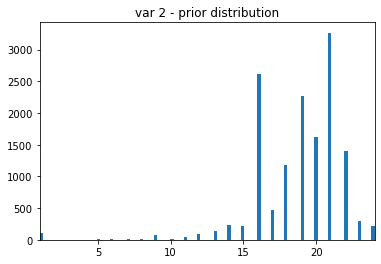

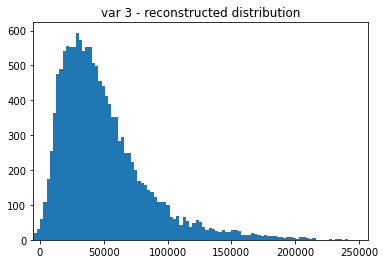

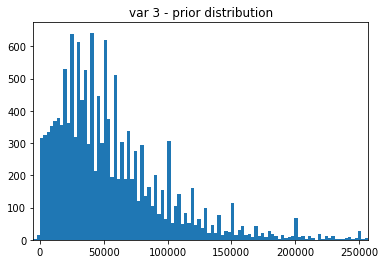

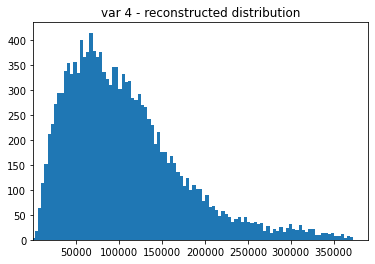

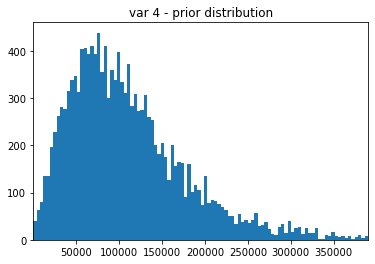

In [19]:
# Show distributions of the resulting numerical variables
for col_idx in range(0, CAT_IDX):
    results_data_plt = results_df.iloc[:,col_idx]
    test_data_plt = test_data_df.iloc[:,col_idx]

    plt.hist(results_data_plt, bins=100)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()

    plt.hist(test_data_plt, bins=100)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()

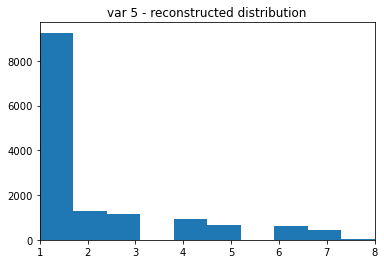

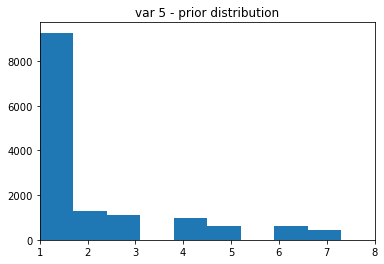

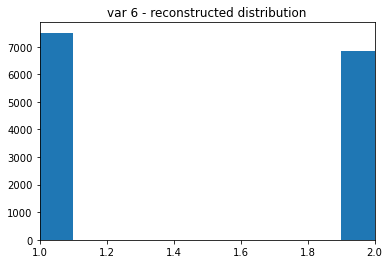

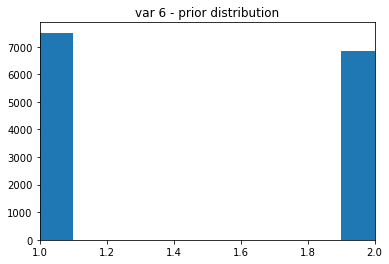

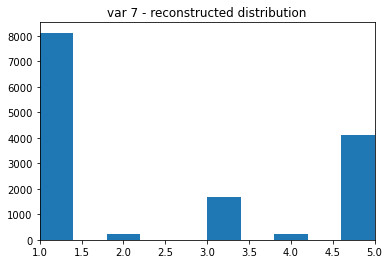

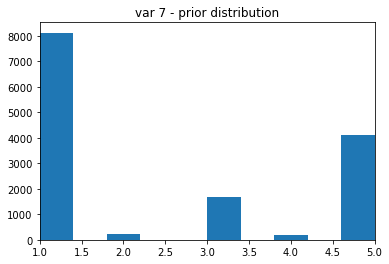

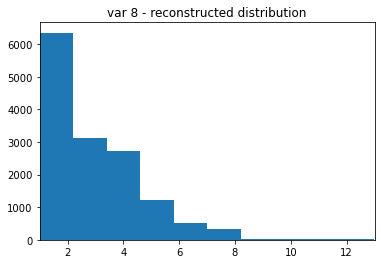

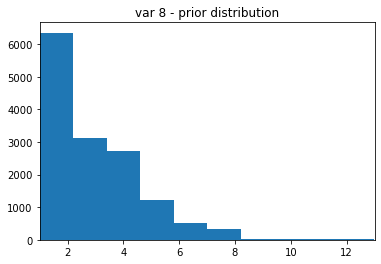

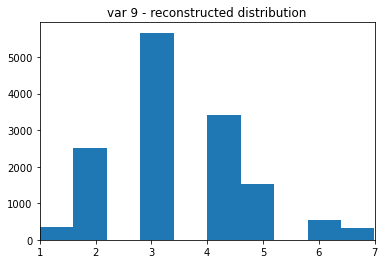

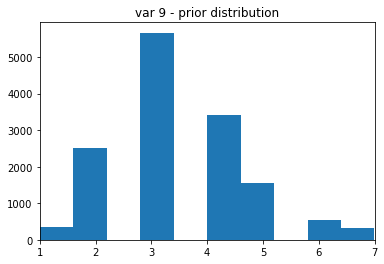

In [20]:
# Show distributions of the resulting numerical variables
for col_idx in range(CAT_IDX, VAR_DIM):
    results_data_plt = results_df.iloc[:,col_idx]
    test_data_plt = test_data_df.iloc[:,col_idx]
    
    plt.hist(results_data_plt)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - reconstructed distribution")
    plt.show()
    
    plt.hist(test_data_plt)
    plt.xlim(min(test_data_plt),max(test_data_plt))
    plt.title(f"var {col_idx} - prior distribution")
    plt.show()

## Generating Synthetic Population